[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ksachdeva/rethinking-tensorflow-probability/blob/master/notebooks/11_god_spiked_the_integers.ipynb)

# 11. God Spiked the Integers

In [189]:
import os
import numpy as np
import arviz as az
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from collections import namedtuple
import statsmodels.formula.api as smf

import random
import jax
import jax.numpy as jnp

import tensorflow as tf
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
# to use 'sample_distributions'
import tensorflow_probability as xtfp
xtfd = xtfp.distributions
xtfb = xtfp.bijectors

key = tfp.util.SeedStream(1004, salt="ch-11")
plt.rcParams['figure.figsize'] = [6, 5]

# TFP often requires 64-bit precision (float64) for certain computations 
# to ensure numerical stability and accuracy, e.g., tfd.Possion.
# However, jax.config.update("jax_enable_x64", True)
# converts all 32 to 64, so that sometimes errors occur.
# e.g., TypeError: Tensor conversion requested dtype 
#   <class 'jax.numpy.int32'> for array with dtype int64
jax.config.update("jax_enable_x64", True)


## 11.1 Binomial regression

### 11.1.1 Logistic regression: Prosocial chimpanzees

##### Code 11.1

Authors start the chapter by highlighting one key difference between **Generalized Linear Models** and **Gaussian Linear Models**. He says, that unlike Gaussian Linear Models where we had some interpretation of parameters, in the case of **GLM** it is the combination of parameters that matter.

Most common & **useful** GLM models are about **counts** but they are also difficult to model. What is the reason for that ?

He says - "When we *wish* to predict the outcome in the form of counts, the scale of parameters is **never the same** as the scale of outcome. This is another way of saying that it is the combination of parameters that help in prediction and hence some where we lose human intution that could have connected the parmaeters with the outcome.


**Binomial Regression** -: model the outcome (count) when both of the categories are known.

**Poisson Regression** -: model the outcome (count) when the maximum count is unknown.



In [4]:
d = pd.read_csv("./data/chimpanzees.csv", sep=";")

##### Code 11.2


We aim to build index variables instead of using dummy variables. Below is a quick way to do it. Treatment here is about the 4 possible situations.

1. prosoc_left= 0 and condition= 0: Two food items on right and no partner. 
2. prosoc_left= 1 and condition= 0: Two food items on left and no partner.
3. prosoc_left= 0 and condition= 1: Two food items on right and partner present.
4. prosoc_left= 1 and condition= 1: Two food items on left and partner present.

In [5]:
# In the book there is an additional 1 in the code snippet.
# That is because of R as in R index does not starts with 0

d["treatment"] = d.prosoc_left + 2 * d.condition

##### Code 11.3

In [6]:
d.groupby(["condition", "prosoc_left", "treatment"]).size()

condition  prosoc_left  treatment
0          0            0            126
           1            1            126
1          0            2            126
           1            3            126
dtype: int64

In [7]:
d.describe()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left,treatment
count,504.000000,252.00000,504.000000,504.000000,504.000000,504.000000,504.00000,504.000000,504.000000
mean,4.000000,5.00000,0.500000,3.500000,36.500000,0.500000,0.56746,0.579365,1.500000
std,2.001987,2.00398,0.500497,1.709522,20.803253,0.500497,0.49592,0.494151,1.119145
min,1.000000,2.00000,0.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000
25%,2.000000,3.00000,0.000000,2.000000,18.750000,0.000000,0.00000,0.000000,0.750000
50%,4.000000,5.00000,0.500000,3.500000,36.500000,0.500000,1.00000,1.000000,1.500000
75%,6.000000,7.00000,1.000000,5.000000,54.250000,1.000000,1.00000,1.000000,2.250000
max,7.000000,8.00000,1.000000,6.000000,72.000000,1.000000,1.00000,1.000000,3.000000


##### Code 11.4

In [8]:
def model_11_1(a_scale):
    def _generator():
        a = yield tfd.Normal(loc=0., scale=a_scale, name='a')
        logit = a
        yield tfd.Binomial(total_count=1., logits=logit, name='pulled_left')

    return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [9]:
jd_11_1 = model_11_1(a_scale=10.)

##### Code 11.5

In [10]:
prior = jd_11_1.sample(1000, seed=key())

##### Code 11.6

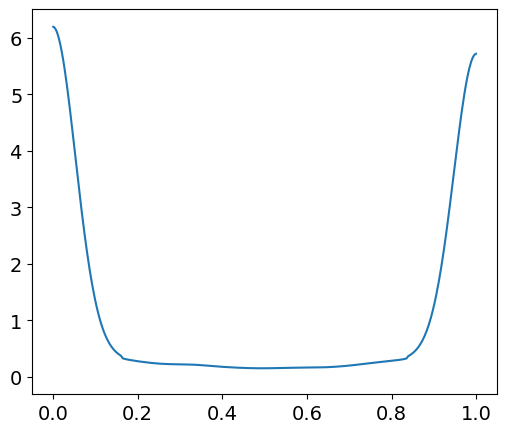

In [11]:
p = jax.nn.sigmoid(prior[0])
az.plot_kde(p)
plt.show()

Most of the probability mass in the above plot is piled up near zero or one. A flat prior in the logit space is not a flat prior in the outcome probability space.

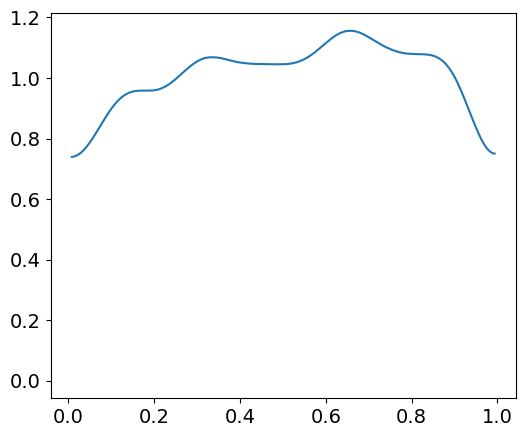

In [12]:
jd_11_1b = model_11_1(a_scale=1.5)
prior_with_1_5 = jd_11_1b.sample(1000, seed=key())

p = jax.nn.sigmoid(prior_with_1_5[0])

az.plot_kde(p)
plt.show()

A more concentrated Normal(0,1.5) prior produces something more reasonable

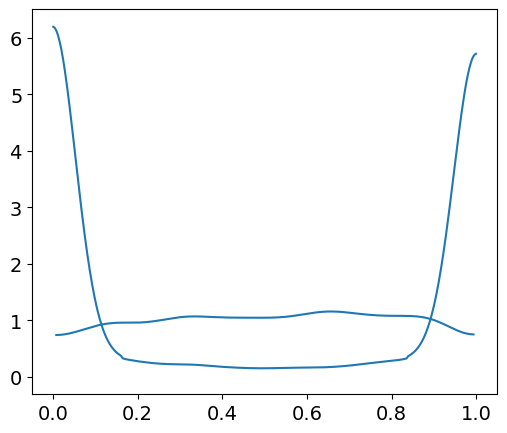

In [13]:
# simply showing both of the above plots
# at the same time to reproduce figure 11.3

p1 = jax.nn.sigmoid(prior[0])
p2 = jax.nn.sigmoid(prior_with_1_5[0])
az.plot_kde(p1)
az.plot_kde(p2)
plt.show()

##### Code 11.7 

In [14]:
d.treatment.unique()

array([0, 1, 2, 3])

In [15]:
def model_11_2(treatments):
    treatments = jnp.array(treatments, dtype=jnp.int32)

    def _generator():
        a = yield tfd.Normal(loc=0.0, scale=1.5, name='a')
        b = yield tfd.Normal(loc=[0., 0, 0, 0], scale=10.0, name='b')
        logit = a + jnp.take(b, treatments)
        yield tfd.Binomial(total_count=1.0, logits=logit, name='pulled_left')

    return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [16]:
jd_11_2 = model_11_2(d.treatment.values)

In [17]:
prior_a, prior_b, _ = jd_11_2.sample(1000, seed=key())

p = jax.nn.sigmoid(prior_a[..., jnp.newaxis] + prior_b)

##### Code 11.8 

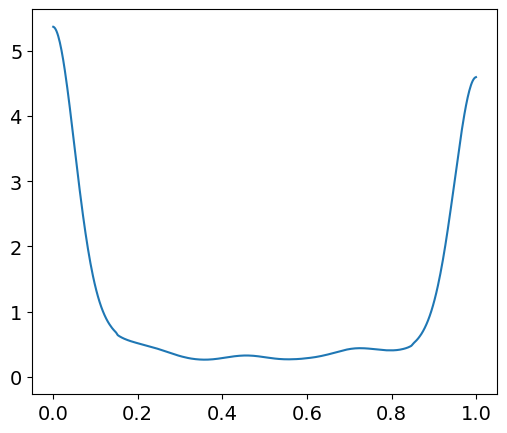

In [18]:
# az.plot_kde(p[:, 0])
az.plot_kde(jnp.abs(p[:, 0] - p[:, 1]))
plt.show()

##### Code 11.9 

Sample model as 11_2 but with a different scale for beta_treatment

In [19]:
def model_11_3(treatments):
    treatments = jnp.array(treatments, dtype=jnp.int32)

    def _generator():
        a = yield tfd.Normal(loc=0.0, scale=1.5, name='a')
        b = yield tfd.Normal(loc=[0., 0, 0, 0], scale=.5, name='b')
        logit = a + jnp.take(b, treatments)
        yield tfd.Binomial(total_count=1.0, logits=logit, name='pulled_left')

    return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [20]:
jd_11_3 = model_11_3(d.treatment.values)

prior_a, prior_b, _ = jd_11_3.sample(1000, seed=key())

p = jax.nn.sigmoid(prior_a[..., jnp.newaxis] + prior_b)

np.mean(jnp.abs(p[:, 0] - p[:, 1]))

Array(0.09510462, dtype=float32)

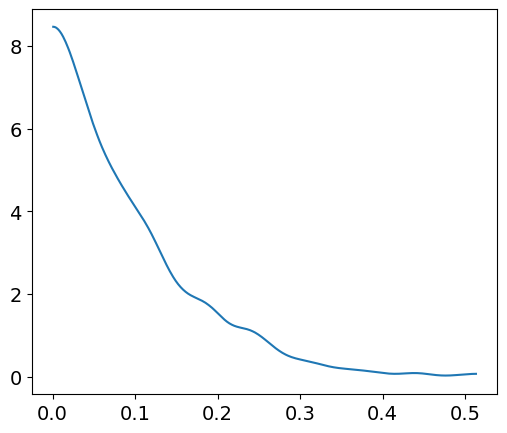

In [21]:
az.plot_kde(jnp.abs(p[:, 0] - p[:, 1]))
plt.show()

##### Code 11.10

In [22]:
d.actor.unique()

array([1, 2, 3, 4, 5, 6, 7])

In [23]:
d["actor_id"] = d.actor.values - 1

##### Code 11.11

In [24]:
def model_11_4(actors, treatments):
    actors = jnp.array(actors, dtype=jnp.int32)
    treatments = jnp.array(treatments, dtype=jnp.int32)

    def _generator():
        a = yield tfd.Sample(tfd.Normal(loc=0.0, scale=1.5), sample_shape=7, name='a')
        b = yield tfd.Normal(loc=[0., 0, 0, 0], scale=.5, name='b')
        logit = jnp.take(a, actors) + jnp.take(b, treatments)
        yield tfd.Binomial(total_count=1.0, logits=logit, name='pulled_left')

    return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [25]:
jd_11_4 = model_11_4(d.actor_id.values, d.treatment.values)

In [26]:
jd_11_4_pin = jd_11_4.experimental_pin(
  pulled_left=jnp.array(d.pulled_left.values, dtype=jnp.float32))

In [27]:
# https://www.tensorflow.org/probability/examples/Modeling_with_JointDistribution
@jax.jit
def run_chain(init_state, seed, step_size=1e-3, num_steps=500, burnin=300):

#   def trace_fn(_, pkr):
#     return (
#         pkr.inner_results.inner_results.target_log_prob,
#         pkr.inner_results.inner_results.leapfrogs_taken,
#         pkr.inner_results.inner_results.has_divergence,
#         pkr.inner_results.inner_results.energy,
#         pkr.inner_results.inner_results.log_accept_ratio)

  def target_log_prob(*states):
    return jd_11_4_pin.unnormalized_log_prob(states)
  
  bijectors = [tfb.Identity(), tfb.Identity()]

  kernel = tfp.mcmc.NoUTurnSampler(
      target_log_prob_fn=target_log_prob,
      step_size=step_size)
  
  kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=kernel,
    bijector=bijectors)

  kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=kernel,
    num_adaptation_steps=burnin,
    # step_size_setter_fn=lambda pkr, new_step_size: pkr._replace(
    #     inner_results=pkr.inner_results._replace(step_size=new_step_size)),
    # step_size_getter_fn=lambda pkr: pkr.inner_results.step_size,
    # log_accept_prob_getter_fn=lambda pkr: pkr.inner_results.log_accept_ratio
  )

  chain_state = tfp.mcmc.sample_chain(
      num_results=num_steps,
      num_burnin_steps=burnin,
      current_state=init_state,
      kernel=kernel,
      seed=seed,
      trace_fn=None)
  
  return chain_state

In [28]:
num_chains = 4
init_state = jd_11_4_pin.sample_unpinned(num_chains, seed=key())

post_4 = run_chain(init_state=init_state, seed=key())

In [29]:
post_4_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_4._asdict().items()}
dict_4 = dict(posterior=post_4_dict)
idata_4 = az.from_dict(**dict_4)

In [30]:
az.summary(idata_4, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.444,0.322,-0.964,0.052,0.008,0.006,1568.0,1561.0,1.00
a[1],3.888,0.730,2.739,5.031,0.024,0.017,973.0,1020.0,1.00
a[2],-0.739,0.331,-1.288,-0.226,0.009,0.006,1470.0,1403.0,1.00
a[3],-0.746,0.333,-1.263,-0.204,0.008,0.006,1568.0,1702.0,1.00
a[4],-0.448,0.326,-0.950,0.094,0.008,0.006,1645.0,1436.0,1.00
a[5],0.485,0.329,0.004,1.059,0.009,0.006,1465.0,1681.0,1.00
a[6],1.958,0.418,1.307,2.660,0.011,0.008,1476.0,1471.0,1.00
b[0],-0.050,0.279,-0.474,0.413,0.007,0.005,1520.0,1575.0,1.00
b[1],0.477,0.278,-0.008,0.883,0.007,0.005,1491.0,1384.0,1.00
b[2],-0.380,0.290,-0.884,0.058,0.008,0.006,1490.0,1565.0,1.00


Clearly interpretation of all these varying parameters is difficult now. The alphas above represent intercepts unique to each chimpanzee. Each of these expresses the tendency of each individual to pull the left lever. 

##### Code 11.12

array([<Axes: title={'center': '89.0% HDI'}>], dtype=object)

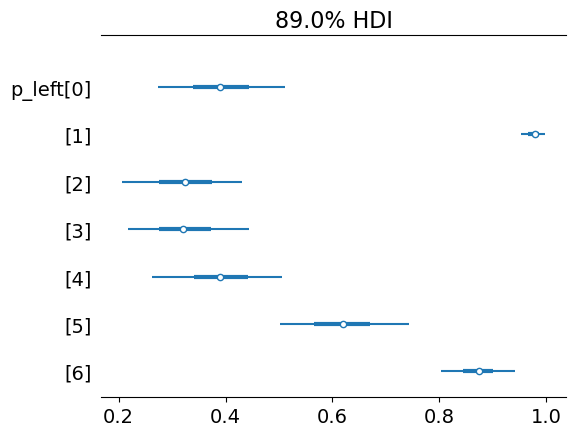

In [31]:
p_left = jax.nn.sigmoid(idata_4.posterior['a'].values)
az.plot_forest({'p_left' : p_left}, combined=True, hdi_prob=0.89)

What above plot shows is that 0,2,3,4 show preference for right lever.
Two chimps (1 & 6) show strong preference for left lever and it is also reflected in the data

##### Code 11.13

Here we are now considering treatment effects and hoping that they are estimated more precisely

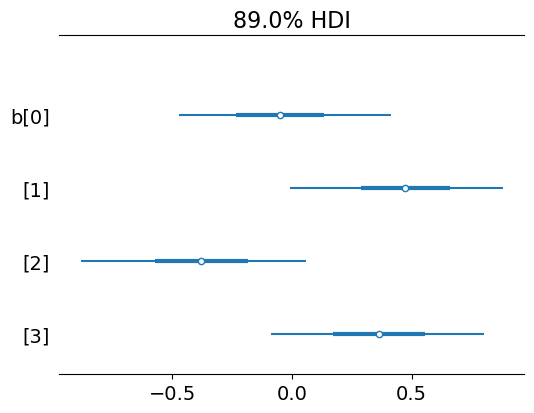

In [32]:
labs = ["R/N", "L/N", "R/P", "L/P"]
az.plot_forest(idata_4, combined=True, var_names="b", hdi_prob=0.89);

* L/N => prosocial on left / no partner
* R/P => proscoial on right / partner

What we are looking for is evidence that the chimpanzees choose the prosocial option more when a partner is present. This implies comparing the first row with the third row and the second row with the fourth row

##### Code 11.14

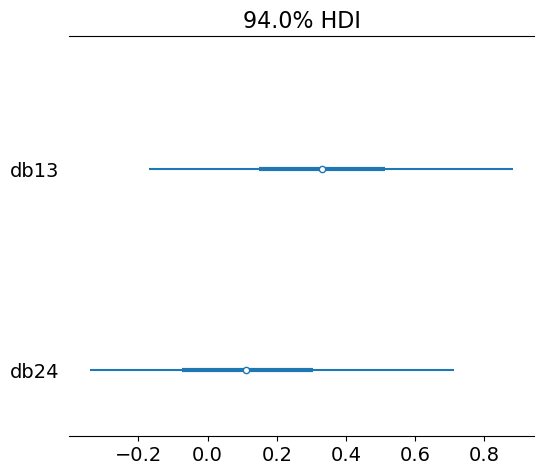

In [33]:
diffs = {
    "db13": idata_4.posterior["b"][..., 0] - idata_4.posterior["b"][..., 2],
    "db24": idata_4.posterior["b"][..., 1] - idata_4.posterior["b"][..., 3],
}
az.plot_forest(diffs, combined=True)
plt.show()

db13 is the difference between no-partner/partner treatments when the prosocial option was on the right.

There is a weak evidence that individual pulled left more when the partner was absent

## Code 11.15

Compute proportion in each combination of actor & treatment

In [34]:
pl = d.groupby(["actor", "treatment"])["pulled_left"].mean().unstack()
pl

treatment,0,1,2,3
actor,,,,
1,0.333333,0.500000,0.277778,0.555556
2,1.000000,1.000000,1.000000,1.000000
3,0.277778,0.611111,0.166667,0.333333
4,0.333333,0.500000,0.111111,0.444444
5,0.333333,0.555556,0.277778,0.500000
6,0.777778,0.611111,0.555556,0.611111
7,0.777778,0.833333,0.944444,1.000000


the cells contain proportions of pulls that were of the left lever

##### Code 11.16

Plotting observed proportions

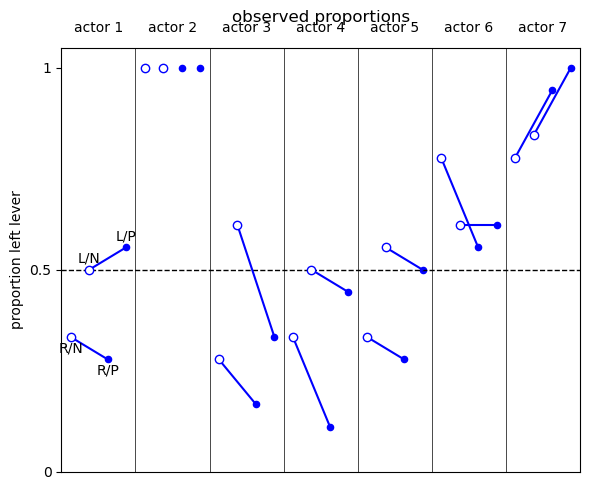

In [35]:
ax = plt.subplot(
    xlim=(0.5, 28.5),
    ylim=(0, 1.05),
    xlabel="",
    ylabel="proportion left lever",
    xticks=[],
)
plt.yticks(ticks=[0, 0.5, 1], labels=[0, 0.5, 1])
ax.axhline(0.5, c="k", lw=1, ls="--")
for j in range(1, 8):
    ax.axvline((j - 1) * 4 + 4.5, c="k", lw=0.5)
for j in range(1, 8):
    ax.annotate(
        "actor {}".format(j),
        ((j - 1) * 4 + 2.5, 1.1),
        ha="center",
        va="center",
        annotation_clip=False,
    )
for j in np.delete(range(1, 8), 1):
    ax.plot((j - 1) * 4 + np.array([1, 3]), pl.loc[j, [0, 2]], "b")
    ax.plot((j - 1) * 4 + np.array([2, 4]), pl.loc[j, [1, 3]], "b")
x = np.arange(1, 29).reshape(7, 4)
ax.scatter(
    x[:, [0, 1]].reshape(-1),
    pl.values[:, [0, 1]].reshape(-1),
    edgecolor="b",
    facecolor="w",
    zorder=3,
)
ax.scatter(
    x[:, [2, 3]].reshape(-1), pl.values[:, [2, 3]].reshape(-1), marker=".", c="b", s=80
)
yoff = 0.01
ax.annotate("R/N", (1, pl.loc[1, 0] - yoff), ha="center", va="top")
ax.annotate("L/N", (2, pl.loc[1, 1] + yoff), ha="center", va="bottom")
ax.annotate("R/P", (3, pl.loc[1, 2] - yoff), ha="center", va="top")
ax.annotate("L/P", (4, pl.loc[1, 3] + yoff), ha="center", va="bottom")
ax.set_title("observed proportions\n")
plt.tight_layout()


##### Code 11.17

In [36]:
dat = {"actor": np.repeat(np.arange(7), 4), "treatment": np.tile(np.arange(4), 7)}

def compute_p_for_given_actor_treatment(params):
    a = params[0]
    t = params[1]
    p = idata_4.posterior["a"].values[0][:, a] + idata_4.posterior["b"].values[0][:, t]
    return jax.nn.sigmoid(p)

params = zip(dat["actor"], dat["treatment"])

p = np.array(list(map(compute_p_for_given_actor_treatment, params))).T

p_mu = np.mean(p, 0)
p_ci = np.percentile(p, q=(4.5, 95.5), axis=0)

##### Code 11.18

In [37]:
d["side"] = d.prosoc_left  # right 0, left 1
d["cond"] = d.condition  # no partner 0, partner 1

##### Code 11.19

In [38]:
def model_11_5(actor, side, cond):
  actor = jnp.array(actor, dtype=jnp.int32)
  side = jnp.array(side, dtype=jnp.int32)
  cond = jnp.array(cond, dtype=jnp.int32)

  def _generator():
    a = yield tfd.Sample(tfd.Normal(loc=0.0, scale=1.5), sample_shape=7, name='a')
    bs = yield tfd.Sample(tfd.Normal(loc=0.0, scale=0.5), sample_shape=2, name='bs')
    bc = yield tfd.Sample(tfd.Normal(loc=0.0, scale=0.5), sample_shape=2, name='bc')
    logits = jnp.take(a, actor) + jnp.take(bs, side) + jnp.take(bc, cond)
    yield tfd.Binomial(total_count=1.0, logits=logits, name='pulled_left')

  return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [39]:
jd_11_5 = model_11_5(d.actor_id.values, d.side.values, d.cond.values)

In [40]:
jd_11_5_pin = jd_11_5.experimental_pin(
  pulled_left=jnp.array(d.pulled_left.values, dtype=jnp.float32))

In [41]:
@jax.jit
def run_chain(init_state, seed, step_size=1e-3, num_steps=500, burnin=300):

  def target_log_prob(*states):
    return jd_11_5_pin.unnormalized_log_prob(states)
  
  bijectors = [tfb.Identity(), tfb.Identity(), tfb.Identity()]

  kernel = tfp.mcmc.NoUTurnSampler(
      target_log_prob_fn=target_log_prob,
      step_size=step_size)
  
  kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=kernel,
    bijector=bijectors)

  kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=kernel,
    num_adaptation_steps=burnin)

  chain_state = tfp.mcmc.sample_chain(
      num_results=num_steps,
      num_burnin_steps=burnin,
      current_state=init_state,
      kernel=kernel,
      seed=seed,
      trace_fn=None)
  
  return chain_state

In [42]:
num_chains = 4
init_state = jd_11_5_pin.sample_unpinned(num_chains, seed=key())

post_5 = run_chain(init_state=init_state, seed=key())

In [43]:
post_5_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_5._asdict().items()}
dict_5 = dict(posterior=post_5_dict)
idata_5 = az.from_dict(**dict_5)

In [44]:
az.summary(idata_5, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.653,0.444,-1.292,0.127,0.015,0.011,828.0,930.0,1.0
a[1],3.784,0.826,2.509,5.121,0.031,0.022,736.0,859.0,1.0
a[2],-0.949,0.445,-1.633,-0.198,0.015,0.011,866.0,1143.0,1.0
a[3],-0.950,0.445,-1.636,-0.204,0.016,0.011,797.0,1037.0,1.0
a[4],-0.652,0.447,-1.325,0.084,0.015,0.011,849.0,1093.0,1.0
a[5],0.270,0.450,-0.471,0.975,0.016,0.011,827.0,1201.0,1.0
a[6],1.765,0.514,1.003,2.648,0.017,0.012,968.0,1244.0,1.0
bc[0],0.273,0.327,-0.287,0.755,0.010,0.007,1141.0,1322.0,1.0
bc[1],0.024,0.327,-0.474,0.567,0.010,0.007,1080.0,1330.0,1.0
bs[0],-0.183,0.333,-0.675,0.393,0.010,0.007,1064.0,1272.0,1.0


##### Code 11.20

We need to compute likelihoods in order to use arviz's compare method

In [45]:
def model_11_4x(actor, treatment):
  actor = tf.convert_to_tensor(actor, dtype=tf.int32)
  treatment = tf.convert_to_tensor(treatment, dtype=tf.int32)

  def _generator():
    a = yield xtfd.Sample(xtfd.Normal(loc=0.0, scale=1.5), sample_shape=7, name='a')
    b = yield xtfd.Normal(loc=[0., 0, 0, 0], scale=.5, name='b')
    logits = tf.gather(a, actor) + tf.gather(b, treatment)
    yield xtfd.Binomial(total_count=1.0, logits=logits, name='pulled_left')

  return xtfd.JointDistributionCoroutineAutoBatched(_generator)

In [46]:
jd_4x = model_11_4x(d.actor_id.values, d.treatment.values)
ds_4, _ = jd_4x.sample_distributions(value=post_4)
ll_4 = ds_4[-1].log_prob(d.pulled_left.values)
ll_4 = np.moveaxis(ll_4, 0, 1) 

In [47]:
dict_4.update(log_likelihood={'ll': ll_4},
              dims={"ll": ["obs"]},
              coords={"obs": np.arange(len(d.pulled_left.values))})
idata_4 = az.from_dict(**dict_4)

In [48]:
def model_11_5x(actor, side, cond):
  actor = tf.convert_to_tensor(actor, dtype=tf.int32)
  side = tf.convert_to_tensor(side, dtype=tf.int32)
  cond = tf.convert_to_tensor(cond, dtype=tf.int32)

  def _generator():
    a = yield xtfd.Sample(xtfd.Normal(loc=0.0, scale=1.5), sample_shape=7, name='a')
    bs = yield xtfd.Sample(xtfd.Normal(loc=0.0, scale=0.5), sample_shape=2, name='bs')
    bc = yield xtfd.Sample(xtfd.Normal(loc=0.0, scale=0.5), sample_shape=2, name='bc')
    logits = tf.gather(a, actor) + tf.gather(bs, side) + tf.gather(bc, cond)
    yield xtfd.Binomial(total_count=1.0, logits=logits, name='pulled_left')

  return xtfd.JointDistributionCoroutineAutoBatched(_generator)

In [49]:
jd_5x = model_11_5x(d.actor_id.values, d.side.values, d.cond.values)
ds, _ = jd_5x.sample_distributions(value=post_5)
ll_5 = ds[-1].log_prob(d.pulled_left.values)
ll_5 = np.moveaxis(ll_5, 0, 1) 

In [50]:
dict_5.update(log_likelihood={'ll': ll_5},
              dims={"ll": ["obs"]},
              coords={"obs": np.arange(len(d.pulled_left.values))})
idata_5 = az.from_dict(**dict_5)

In [51]:
az.compare({"m11.5": idata_5, "m11.4": idata_4}, ic='loo', scale="deviance")

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
m11.5,0,530.592546,7.726895,0.000000,1.0,19.128082,0.000000,False,deviance
m11.4,1,532.427182,8.567087,1.834636,0.0,18.919016,1.270507,False,deviance


### 11.1.2 Relative shark and absolute penguin

##### Code 11.23

In [52]:
np.mean(np.exp(post_4_dict['b'][:, :, 3] - post_4_dict['b'][:, :, 1]))

0.9265165

### Aggregated binomial: Chimpanzees again,condensed

##### Code 11.24

In [53]:
d = pd.read_csv("./data/chimpanzees.csv", sep=";")
d["treatment"] = d.prosoc_left + 2 * d.condition
d["side"] = d.prosoc_left  # right 0, left 1
d["cond"] = d.condition  # no partner 0, partner 1
d_aggregated = (
    d.groupby(["treatment", "actor", "side", "cond"])["pulled_left"].sum().reset_index()
)
d_aggregated.rename(columns={"pulled_left": "left_pulls"}, inplace=True)

d_aggregated["actor_id"] = d_aggregated["actor"].values - 1

##### Code 11.25

In [54]:
def model_11_6(actor, treatment):
  actor = jnp.array(actor, dtype=jnp.int32)
  treatment = jnp.array(treatment, dtype=jnp.int32)

  def _generator():
    a = yield tfd.Sample(tfd.Normal(loc=0.0, scale=1.5), sample_shape=7, name='a')
    b = yield tfd.Sample(tfd.Normal(loc=0.0, scale=0.5), sample_shape=4, name='b')
    logits = jnp.take(a, actor) + jnp.take(b, treatment)
    yield tfd.Binomial(total_count=18.0, logits=logits, name='left_pulls')

  return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [65]:
jd_11_6 = model_11_6(d_aggregated.actor_id.values, d_aggregated.treatment.values)

In [66]:
jd_11_6_pin = jd_11_6.experimental_pin(
  left_pulls=jnp.array(d_aggregated.left_pulls.values, dtype=jnp.float32))

In [67]:
@jax.jit
def run_chain(init_state, seed, step_size=1e-3, num_steps=500, burnin=300):

  def target_log_prob(*states):
    return jd_11_6_pin.unnormalized_log_prob(states)
  
  bijectors = [tfb.Identity(), tfb.Identity()]

  kernel = tfp.mcmc.NoUTurnSampler(
      target_log_prob_fn=target_log_prob,
      step_size=step_size)
  
  kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=kernel,
    bijector=bijectors)

  kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=kernel,
    num_adaptation_steps=burnin)

  chain_state = tfp.mcmc.sample_chain(
      num_results=num_steps,
      num_burnin_steps=burnin,
      current_state=init_state,
      kernel=kernel,
      seed=seed,
      trace_fn=None)
  
  return chain_state

In [68]:
num_chains = 4
init_state = jd_11_6_pin.sample_unpinned(num_chains, seed=key())
# StateTuple = namedtuple("StateTuple", ['a', 'b'])
# init_state = StateTuple(jnp.zeros((num_chains, 7)), jnp.zeros((num_chains, 4)))
post_6 = run_chain(init_state=init_state, seed=key(), burnin=500)

In [69]:
post_6_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_6._asdict().items()}
dict_6 = dict(posterior=post_6_dict)
idata_6 = az.from_dict(**dict_6)

In [70]:
az.summary(idata_6, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.442,0.339,-0.992,0.090,0.009,0.007,1446.0,1290.0,1.0
a[1],3.890,0.757,2.658,4.997,0.022,0.016,1169.0,877.0,1.0
a[2],-0.741,0.336,-1.222,-0.136,0.009,0.006,1410.0,1547.0,1.0
a[3],-0.736,0.341,-1.318,-0.251,0.009,0.006,1385.0,1541.0,1.0
a[4],-0.440,0.332,-1.001,0.050,0.008,0.006,1588.0,1689.0,1.0
a[5],0.491,0.334,-0.082,0.999,0.008,0.006,1541.0,1431.0,1.0
a[6],1.975,0.420,1.357,2.689,0.012,0.009,1295.0,1347.0,1.0
b[0],-0.054,0.285,-0.531,0.388,0.008,0.006,1320.0,1560.0,1.0
b[1],0.472,0.298,-0.027,0.934,0.008,0.006,1386.0,1419.0,1.0
b[2],-0.391,0.285,-0.836,0.083,0.008,0.005,1376.0,1423.0,1.0


##### Code 11.26 (Find a way to get the comparison even if different number of obs)

In [77]:
def model_11_6x(actor, treatment):
  actor = tf.convert_to_tensor(actor, dtype=tf.int32)
  treatment = tf.convert_to_tensor(treatment, dtype=tf.int32)

  def _generator():
    a = yield xtfd.Sample(xtfd.Normal(loc=0.0, scale=1.5), sample_shape=7, name='a')
    b = yield xtfd.Sample(xtfd.Normal(loc=0.0, scale=0.5), sample_shape=4, name='b')
    logits = tf.gather(a, actor) + tf.gather(b, treatment)
    yield xtfd.Binomial(total_count=18.0, logits=logits, name='left_pulls')

  return xtfd.JointDistributionCoroutineAutoBatched(_generator)

In [80]:
jd_6x = model_11_6x(d_aggregated.actor_id.values, d_aggregated.treatment.values)
ds, _ = jd_6x.sample_distributions(value=post_6)
ll_6 = ds[-1].log_prob(tf.convert_to_tensor(d_aggregated.left_pulls.values, dtype=tf.float32))
ll_6 = np.moveaxis(ll_6, 0, 1) 

In [81]:
dict_6.update(log_likelihood={'ll': ll_6},
              dims={"ll": ["obs"]},
              coords={"obs": np.arange(len(d_aggregated.left_pulls.values))})
idata_6 = az.from_dict(**dict_6)

In [ ]:
# in order to use comparison the number of observations should be same
# which is not the case with m11.4 (504) and m11.6 (28)
# az.compare({"m11.6": idata_6, "m11.4": idata_4}, ic='loo', scale="deviance")

##### Code 11.27

In [83]:
# deviance of aggregated 6-in-9
print(-2 * tfd.Binomial(total_count=9.0, probs=0.2).log_prob(6))
# deviance of dis-aggregated
print(
    -2
    * np.sum(tfd.Bernoulli(probs=0.2).log_prob(np.array([1, 1, 1, 1, 1, 1, 0, 0, 0])))
)

11.790481
20.652117


### 11.1.4 Aggregated binomial: Graduate school admissions

##### Code 11.28

Evaluate if there is a gender bias in admissions

In [84]:
d = pd.read_csv("./data/UCBadmit.csv", sep=";")
d["gid"] = (d["applicant.gender"] != "male").astype(int)
d

,dept,applicant.gender,admit,reject,applications,gid
1,A,male,512,313,825,0
2,A,female,89,19,108,1
3,B,male,353,207,560,0
4,B,female,17,8,25,1
5,C,male,120,205,325,0
6,C,female,202,391,593,1
7,D,male,138,279,417,0
8,D,female,131,244,375,1
9,E,male,53,138,191,0
10,E,female,94,299,393,1


There are 12 rows in the above dataset however they collectively represent 4526 applications. Counting the rows in the data table is not a sensible way to assess sample size

##### Code 11.29

We will model the admission as the outcome that depends on the gender

In [87]:
def model_11_7(gid, applications):
  gid = jnp.array(gid, dtype=jnp.int32)
  applications = jnp.array(applications, dtype=jnp.float32)
  
  def _generator():
    a = yield tfd.Sample(tfd.Normal(loc=0.0, scale=1.5), sample_shape=2, name='a')
    logits = jnp.take(a, gid)
    yield tfd.Binomial(total_count=applications, logits=logits, name='admit')

  return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [88]:
jd_11_7 = model_11_7(d.gid.values, d.applications.values)

In [89]:
jd_11_7_pin = jd_11_7.experimental_pin(
  admit=jnp.array(d.admit.values, dtype=jnp.float32))

In [90]:
@jax.jit
def run_chain(init_state, seed, step_size=1e-3, num_steps=500, burnin=300):

  def target_log_prob(*states):
    return jd_11_7_pin.unnormalized_log_prob(states)
  
  bijectors = [tfb.Identity()]

  kernel = tfp.mcmc.NoUTurnSampler(
      target_log_prob_fn=target_log_prob,
      step_size=step_size)
  
  kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=kernel,
    bijector=bijectors)

  kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=kernel,
    num_adaptation_steps=burnin)

  chain_state = tfp.mcmc.sample_chain(
      num_results=num_steps,
      num_burnin_steps=burnin,
      current_state=init_state,
      kernel=kernel,
      seed=seed,
      trace_fn=None)
  
  return chain_state

In [91]:
num_chains = 4
init_state = jd_11_7_pin.sample_unpinned(num_chains, seed=key())
post_7 = run_chain(init_state=init_state, seed=key(), burnin=400)

In [92]:
post_7_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_7._asdict().items()}
dict_7 = dict(posterior=post_7_dict)
idata_7 = az.from_dict(**dict_7)

In [93]:
az.summary(idata_7, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.221,0.040,-0.289,-0.160,0.001,0.001,1603.0,1615.0,1.01
a[1],-0.829,0.051,-0.919,-0.754,0.001,0.001,1657.0,1285.0,1.00


##### Code 11.30

Posterior of males is higher than females, here we compute the contrast

In [96]:
diff_a = idata_7.posterior["a"][:, :, 0] - idata_7.posterior["a"][:, :, 1]
idata_7.posterior["diff_a"] = diff_a

# to add diff_p have to do lot of massaging to make xarray happy !
diff_p = jax.nn.sigmoid(idata_7.posterior["a"][:, :, 0].values) - jax.nn.sigmoid(
  idata_7.posterior["a"][:, :, 1].values)

coords = [idata_7.posterior.coords["chain"], idata_7.posterior.coords["draw"]]
idata_7.posterior["diff_p"] = xr.DataArray(
    diff_p, coords=coords, dims=["chain", "draw"])

az.summary(idata_7, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.221,0.040,-0.289,-0.160,0.001,0.001,1603.0,1615.0,1.01
a[1],-0.829,0.051,-0.919,-0.754,0.001,0.001,1657.0,1285.0,1.00
diff_a,0.609,0.065,0.505,0.707,0.002,0.001,1658.0,1423.0,1.00
diff_p,0.141,0.015,0.117,0.162,0.000,0.000,1659.0,1423.0,1.00


Log odds difference is certainly positive, corresponding to a higher prob of admissions for male applicants. 

##### Code 11.31

In [114]:
# compute the posterior predictive given the posterior parameters
N = jnp.array(d.applications.values, dtype=jnp.float32)
gid = d.gid.values

# only picking the first chain
a = post_7_dict['a'][0]

# jnp.take(a, gid, axis=1)
sample_logits = jnp.take(a, gid, axis=1)

dist = tfd.Binomial(total_count=N, logits=sample_logits)

# taking the samples from first chain
predictive_samples = dist.sample(seed=key())

(500, 12)

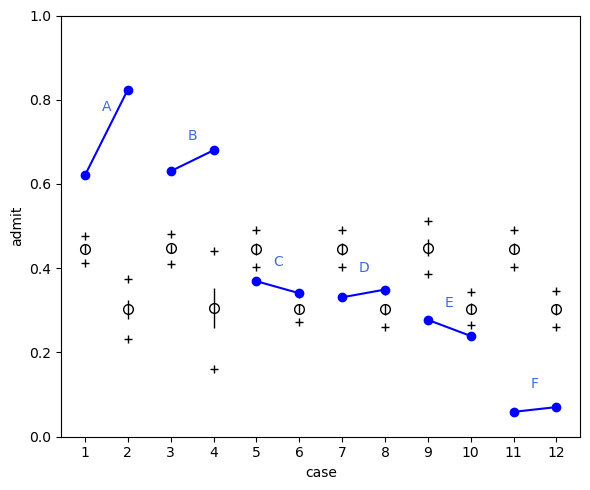

In [117]:
admit_rate = predictive_samples / N

plt.errorbar(
    range(1, 13),
    np.mean(admit_rate, 0),
    np.std(admit_rate, 0) / 2,
    fmt="o",
    c="k",
    mfc="none",
    ms=7,
    elinewidth=1,
)
plt.plot(range(1, 13), np.percentile(admit_rate, 5.5, 0), "k+")
plt.plot(range(1, 13), np.percentile(admit_rate, 94.5, 0), "k+")
# draw lines connecting points from same dept
for i in range(1, 7):
    x = 1 + 2 * (i - 1)
    y1 = d.admit.iloc[x - 1] / d.applications.iloc[x - 1]
    y2 = d.admit.iloc[x] / d.applications.iloc[x]
    plt.plot((x, x + 1), (y1, y2), "bo-")
    plt.annotate(
        d.dept.iloc[x], (x + 0.5, (y1 + y2) / 2 + 0.05), ha="center", color="royalblue"
    )
plt.gca().set(ylim=(0, 1), xticks=range(1, 13), ylabel="admit", xlabel="case")
plt.tight_layout()

What above plot shows is that only for departments C & E, there was a lower rate of admissions for females. Now this is not in sync with what we observed earlier where the model was telling that females should expect an overall 14% lower chance of admission. 

What is going on ?

Problem here is that male and females do not apply to same departments & departments also vary in their rate of admissions. Females do not apply to A & B that has higher rate of acceptance. Instead they applied to departments that have lower rate (10% of applicants) of acceptance.



##### Code 11.32

Changing the question to be asked -

Instead of asking - 

*What are the average probabilities of admission for females and males across all departments?* 

we are now going to ask -

*What is the average difference in probability of admis- sion between females and males within departments?*

In [127]:
def model_11_8(gid, dept_id, applications):
  gid = jnp.array(gid, dtype=jnp.int32)
  dept_id = jnp.array(dept_id, dtype=jnp.int32)
  applications = jnp.array(applications, dtype=jnp.float32)
  
  def _generator():
    a = yield tfd.Sample(tfd.Normal(loc=0.0, scale=1.5), sample_shape=2, name='a')
    delta = yield tfd.Sample(tfd.Normal(loc=0.0, scale=1.5), sample_shape=6, name='delta')
    logits = jnp.take(a, gid) + jnp.take(delta, dept_id)
    yield tfd.Binomial(total_count=applications, logits=logits, name='admit')

  return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [128]:
jd_11_8 = model_11_8(d.gid.values, d.dept.factorize()[0], d.applications.values)

In [132]:
jd_11_8_pin = jd_11_8.experimental_pin(
  admit=jnp.array(d.admit.values, dtype=jnp.float32))

In [130]:
@jax.jit
def run_chain(init_state, seed, step_size=1e-3, num_steps=500, burnin=300):

  def target_log_prob(*states):
    return jd_11_8_pin.unnormalized_log_prob(states)
  
  bijectors = [tfb.Identity(), tfb.Identity()]

  kernel = tfp.mcmc.NoUTurnSampler(
      target_log_prob_fn=target_log_prob,
      step_size=step_size)
  
  kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=kernel,
    bijector=bijectors)

  kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=kernel,
    num_adaptation_steps=burnin)

  chain_state = tfp.mcmc.sample_chain(
      num_results=num_steps,
      num_burnin_steps=burnin,
      current_state=init_state,
      kernel=kernel,
      seed=seed,
      trace_fn=None)
  
  return chain_state

In [133]:
num_chains = 4
init_state = jd_11_8_pin.sample_unpinned(num_chains, seed=key())
post_8 = run_chain(init_state=init_state, seed=key(), burnin=400)

In [134]:
post_8_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_8._asdict().items()}
dict_8 = dict(posterior=post_8_dict)
idata_8 = az.from_dict(**dict_8)

In [135]:
az.summary(idata_8, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.522,0.534,-1.387,0.261,0.031,0.023,290.0,225.0,1.01
a[1],-0.425,0.534,-1.260,0.388,0.031,0.023,300.0,211.0,1.01
delta[0],1.103,0.537,0.260,1.937,0.032,0.022,293.0,208.0,1.01
delta[1],1.060,0.539,0.267,1.945,0.031,0.022,308.0,219.0,1.01
delta[2],-0.162,0.536,-0.941,0.742,0.031,0.028,300.0,231.0,1.01
delta[3],-0.192,0.539,-1.088,0.594,0.031,0.028,298.0,210.0,1.01
delta[4],-0.632,0.539,-1.460,0.211,0.031,0.026,301.0,217.0,1.01
delta[5],-2.187,0.545,-3.034,-1.314,0.031,0.023,307.0,242.0,1.01


##### Code 11.33

Computing the contrast

In [145]:
diff_a = post_8_dict['a'][..., 0] - post_8_dict['a'][..., 1]
diff_p = jax.nn.sigmoid(post_8_dict['a'][..., 0]) - jax.nn.sigmoid(post_8_dict['a'][..., 1])

diffs = az.from_dict(**dict(posterior={'diff_a': diff_a, 'diff_p': diff_p}))
az.summary(diffs, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
diff_a,-0.097,0.080,-0.233,0.025,0.002,0.001,2413.0,1759.0,1.0
diff_p,-0.022,0.018,-0.051,0.007,0.000,0.000,2365.0,1778.0,1.0


##### Code 11.34

In [146]:
dept_id = d.dept.factorize()[0]

pg = np.stack(
    list(
        map(
            lambda k: np.divide(
                d.applications[dept_id == k].values, d.applications[dept_id == k].sum()
            ),
            range(6),
        )
    ),
    axis=0,
).T
pg = pd.DataFrame(pg, index=["male", "female"], columns=d.dept.unique())
pg.round(2)


,A,B,C,D,E,F
male,0.88,0.96,0.35,0.53,0.33,0.52
female,0.12,0.04,0.65,0.47,0.67,0.48


Department A receives 88% of its applications from males. Department E receives 33% from males. 

## 11.2 Poisson regression

##### Code 11.35


Binomial is good when the count is known but quite often it is not the case.

When the count goes extremely high then mean and variance of Binomial starts to become same and this is known as Poisson Distribution


In [197]:
y = tfd.Binomial(1000, probs=1 / 1000).sample(10000, seed=key())
jnp.mean(y), jnp.var(y)

(Array(0.9982, dtype=float32), Array(0.98779696, dtype=float32))

Useful for binomial events for which the number of trials N is unknown or uncountably large.

##### Code 11.36

Counts of unique tool types for 10 historical Oceanic societies

In [198]:
d = pd.read_csv("./data/Kline.csv", sep=";")
d

,culture,population,contact,total_tools,mean_TU
0,Malekula,1100,low,13,3.2
1,Tikopia,1500,low,22,4.7
2,Santa Cruz,3600,low,24,4.0
3,Yap,4791,high,43,5.0
4,Lau Fiji,7400,high,33,5.0
5,Trobriand,8000,high,19,4.0
6,Chuuk,9200,high,40,3.8
7,Manus,13000,low,28,6.6
8,Tonga,17500,high,55,5.4
9,Hawaii,275000,low,71,6.6


To remember - Number of rows in count based models is not same as the sample size

##### Code 11.37

Here the outcome variable is **total tools**

We want to establish a relationship between **log population** and our outcome variable.

We also want to see the interaction between **contact** and **log population**

So first and foremost let's create a column for **log population**


In [199]:
d["P"] = d.population.pipe(np.log).pipe(lambda x: (x - x.mean()) / x.std())
d["contact_id"] = (d.contact == "high").astype(int)

##### Code 11.38

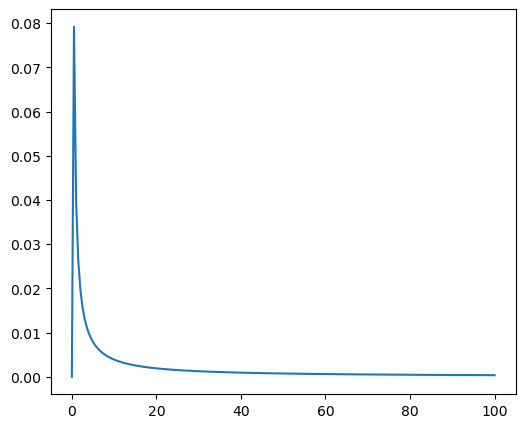

In [4]:
x = jnp.linspace(0, 100, 200)
plt.plot(x, tfd.LogNormal(loc=0.0, scale=10.0).prob(x))
plt.show()

##### Code 11.39

In [6]:
a = tfd.Normal(loc=0.0, scale=10.0).sample(1000, seed=key())
lambda_ = jnp.exp(a)
jnp.mean(lambda_)

Array(1.0910003e+11, dtype=float32)

##### Code 11.40

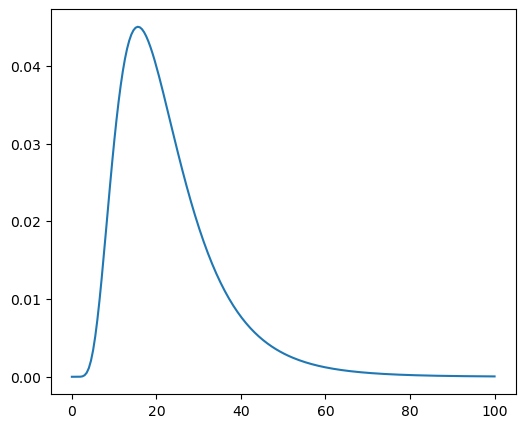

In [7]:
x = np.linspace(0, 100, 200)
plt.plot(x, tfd.LogNormal(loc=3.0, scale=0.5).prob(x))
plt.show()

##### Code 11.41

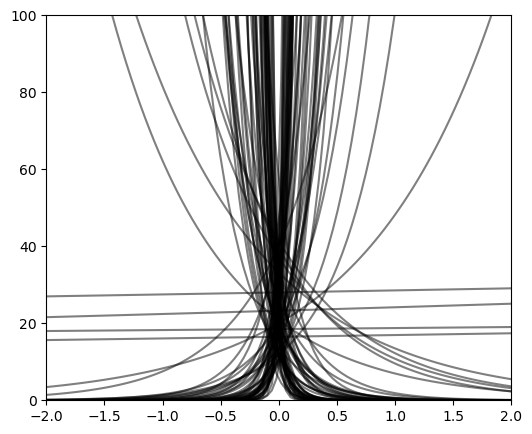

In [8]:
N = 100
a = tfd.Normal(loc=3.0, scale=0.5).sample(N, seed=key())
b = tfd.Normal(loc=0.0, scale=10.0).sample(N, seed=key())
plt.subplot(xlim=(-2, 2), ylim=(0, 100))
x = np.linspace(-2, 2, 100)
for i in range(N):
    plt.plot(x, jnp.exp(a[i] + b[i] * x), c="k", alpha=0.5)

##### Code 11.42

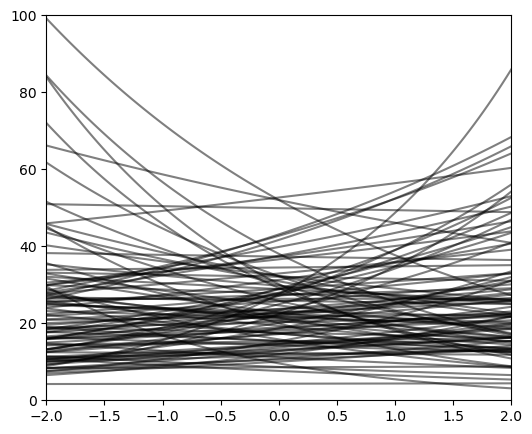

In [9]:
N = 100
a = tfd.Normal(loc=3.0, scale=0.5).sample(N, seed=key())
b = tfd.Normal(loc=0.0, scale=0.2).sample(N, seed=key())
plt.subplot(xlim=(-2, 2), ylim=(0, 100))
x = np.linspace(-2, 2, 100)
for i in range(N):
    plt.plot(x, jnp.exp(a[i] + b[i] * x), c="k", alpha=0.5)

##### Code 11.43

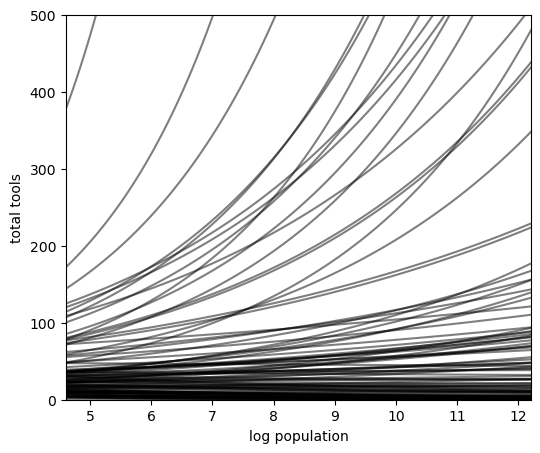

In [10]:
x_seq = np.linspace(np.log(100), np.log(200000), num=100)
lambda_ = np.array(list(map(lambda x: np.exp(a + b * x), x_seq)))

plt.subplot(
    xlim=(np.min(x_seq).item(), np.max(x_seq).item()),
    ylim=(0, 500),
    xlabel="log population",
    ylabel="total tools",
)

plt.plot(x_seq, lambda_, c="k", alpha=0.5)
plt.show()

##### Code 11.44

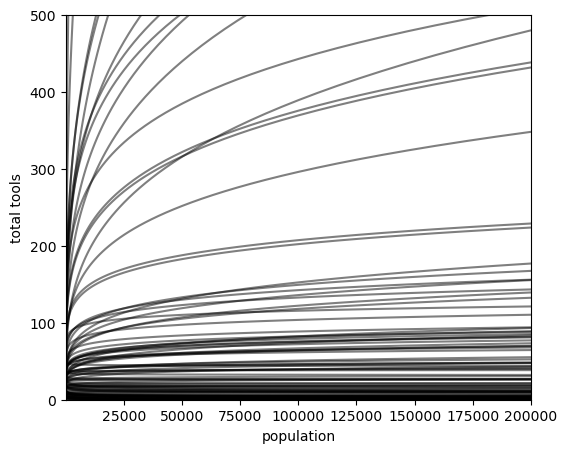

In [11]:
plt.subplot(
    xlim=(np.min(np.exp(x_seq)).item(), np.max(np.exp(x_seq)).item()),
    ylim=(0, 500),
    xlabel="population",
    ylabel="total tools",
)
plt.plot(np.exp(x_seq), lambda_, c="k", alpha=0.5)
plt.show()

##### Code 11.45

In [200]:
# intercept only
def model_11_9():
	def _generator():
		a = yield tfd.Sample(tfd.Normal(loc=3.0, scale=0.5), sample_shape=1, name='a')
		yield tfd.Poisson(log_rate=a, name='T')

	return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [201]:
jd_11_9 = model_11_9()

In [202]:
total_tools = jnp.array(d.total_tools.values, dtype=jnp.float32)
jd_11_9_pin = jd_11_9.experimental_pin(T=total_tools)

In [209]:
@jax.jit
def run_chain(init_state, seed, step_size=1e-3, num_steps=500, burnin=300):
  # To avoid
  # TypeError: Tensor conversion requested dtype <class 'jax.numpy.int32'> 
	#   for array with dtype int64
  burnin = jnp.array(burnin, dtype=jnp.int32)

  def target_log_prob(*states):
    return jd_11_9_pin.unnormalized_log_prob(states)
  
  bijectors = [tfb.Identity()]

  kernel = tfp.mcmc.NoUTurnSampler(
      target_log_prob_fn=target_log_prob,
      step_size=step_size)
  
  kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=kernel,
    bijector=bijectors)

  kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=kernel,
    num_adaptation_steps=burnin)

  chain_state = tfp.mcmc.sample_chain(
      num_results=num_steps,
      num_burnin_steps=burnin,
      current_state=init_state,
      kernel=kernel,
      seed=seed,
      trace_fn=None)
  
  return chain_state

In [210]:
num_chains = 4
init_state = jd_11_9_pin.sample_unpinned(num_chains, seed=key())
post_9 = run_chain(init_state=init_state, seed=key(), burnin=400)

In [211]:
post_9_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_9._asdict().items()}
dict_9 = dict(posterior=post_9_dict)
idata_9 = az.from_dict(**dict_9)

In [212]:
az.summary(idata_9, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],3.54,0.055,3.458,3.632,0.002,0.001,935.0,1504.0,1.0


In [213]:
# interaction model
def model_11_10(cid, P):
	def _generator():
		a = yield tfd.Normal(loc=[3.0, 3.0], scale=0.5, name='a')
		b = yield tfd.Normal(loc=[0.0, 0.0], scale=0.2, name='b')
		log_lambda = jnp.take(a, cid) + jnp.take(b, cid) * P
		yield tfd.Poisson(log_rate=log_lambda, name='T')

	return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [214]:
jd_11_10 = model_11_10(d.contact_id.values, d.P.values)

In [215]:
jd_11_10_pin = jd_11_10.experimental_pin(T=d.total_tools.values)

In [216]:
@jax.jit
def run_chain(init_state, seed, step_size=1e-3, num_steps=500, burnin=300):

  def target_log_prob(*states):
    return jd_11_10_pin.unnormalized_log_prob(states)
  
  bijectors = [tfb.Identity(), tfb.Identity()]

  kernel = tfp.mcmc.NoUTurnSampler(
      target_log_prob_fn=target_log_prob,
      step_size=step_size)
  
  kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=kernel,
    bijector=bijectors)

  kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=kernel,
    num_adaptation_steps=burnin)

  chain_state = tfp.mcmc.sample_chain(
      num_results=num_steps,
      num_burnin_steps=burnin,
      current_state=init_state,
      kernel=kernel,
      seed=seed,
      trace_fn=None)
  
  return chain_state

In [217]:
num_chains = 4
init_state = jd_11_10_pin.sample_unpinned(num_chains, seed=key())
post_10 = run_chain(init_state=init_state, seed=key())

In [218]:
post_10_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_10._asdict().items()}
dict_10 = dict(posterior=post_10_dict)
idata_10 = az.from_dict(**dict_10)

In [219]:
az.summary(idata_10, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],3.322,0.088,3.188,3.462,0.002,0.001,1822.0,1604.0,1.00
a[1],3.610,0.072,3.493,3.720,0.002,0.001,2138.0,1584.0,1.00
b[0],0.377,0.052,0.301,0.467,0.001,0.001,2216.0,1588.0,1.00
b[1],0.185,0.156,-0.064,0.432,0.005,0.004,925.0,939.0,1.01


##### Code 11.46  

In [156]:
# intercept only
def model_11_9x():
	def _generator():
		a = yield xtfd.Sample(xtfd.Normal(loc=3.0, scale=0.5), sample_shape=1, name='a')
		yield xtfd.Poisson(log_rate=a, name='T')

	return xtfd.JointDistributionCoroutineAutoBatched(_generator)

In [157]:
jd_9x = model_11_9x()
ds_9, _ = jd_9x.sample_distributions(value=post_9)
ll_9 = ds_9[-1].log_prob(d.total_tools.values)
ll_9 = np.moveaxis(ll_9, 0, 1) 

In [159]:
dict_9.update(log_likelihood={'ll': ll_9},
              dims={'ll': ['culture']},
              coords={'culture': d.culture.values})
idata_9 = az.from_dict(**dict_9)

In [135]:
# interaction model
def model_11_10x(cid, P):
	def _generator():
		a = yield xtfd.Normal(loc=[3.0, 3.0], scale=0.5, name='a')
		b = yield xtfd.Normal(loc=[0.0, 0.0], scale=0.2, name='b')
		log_lambda = tf.gather(a, cid) + tf.gather(b, cid) * P
		yield xtfd.Poisson(log_rate=log_lambda, name='T')

	return xtfd.JointDistributionCoroutineAutoBatched(_generator)

In [136]:
jd_10x = model_11_10x(d.contact_id.values, d.P.values)
ds_10, _ = jd_10x.sample_distributions(value=post_10)
ll_10 = ds_10[-1].log_prob(d.total_tools.values)
ll_10 = np.moveaxis(ll_10, 0, 1) 

In [137]:
dict_10.update(log_likelihood={'ll': ll_10},
              dims={'ll': ['culture']},
              coords={'culture': d.culture.values})
idata_10 = az.from_dict(**dict_10)

In [160]:
az.compare({"m11.9": idata_9, "m11.10": idata_10}, ic='loo', scale="deviance")

/Users/jun/miniforge3/envs/dl/lib/python3.12/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/jun/miniforge3/envs/dl/lib/python3.12/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
m11.10,0,84.304236,6.452423,0.000000,0.962789,12.279325,0.000000,True,deviance
m11.9,1,141.002675,7.921044,56.698439,0.037211,31.811849,31.553552,True,deviance


##### Code 11.47

/Users/jun/miniforge3/envs/dl/lib/python3.12/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


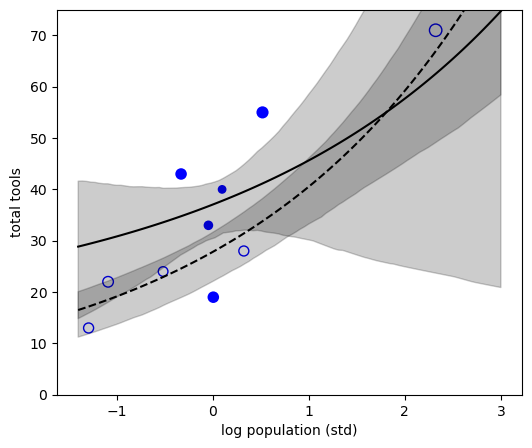

In [178]:
k = az.loo(idata_10, pointwise=True).pareto_k.values

cex = 1 + (k - np.min(k)) / (np.max(k) - np.min(k))
plt.scatter(
    d.P,
    d.total_tools,
    s=40 * cex,
    edgecolors=["none" if i == 1 else "b" for i in d.contact_id],
    facecolors=["none" if i == 0 else "b" for i in d.contact_id],
)
plt.gca().set(xlabel="log population (std)", ylabel="total tools", ylim=(0, 75))

P_seq = np.linspace(-1.4, 3, num=100)

jd_10_cid0 = model_11_10x(cid=np.repeat(0, 100), P=P_seq)
ds_cid0, _ = jd_10_cid0.sample_distributions(value=post_10)
lambda_0 = ds_cid0[-1].mean()
lmu0 = np.mean(lambda_0, axis=(0, 1))
lci0 = np.percentile(lambda_0, (0.55, 94.5), axis=(0, 1))
plt.plot(P_seq, lmu0, "k--", lw=1.5)
plt.fill_between(P_seq, lci0[0], lci0[1], color="k", alpha=0.2)

jd_10_cid1 = model_11_10x(cid=np.repeat(1, 100), P=P_seq)
ds_cid1, _ = jd_10_cid1.sample_distributions(value=post_10)
lambda_1 = ds_cid1[-1].mean()
lmu1 = np.mean(lambda_1, axis=(0, 1))
lci1 = np.percentile(lambda_1, (0.55, 94.5), axis=(0, 1))
plt.plot(P_seq, lmu1, "k", lw=1.5)
plt.fill_between(P_seq, lci1[0], lci1[1], color="k", alpha=0.2);

Open points are low contact societies and closed points are the high contact ones. Dashed curve is the posterior mean for low contact societies.

### 11.2.2 Negative binomial (gamm-poisson) models

### 11.2.3 Example: Exposure and the offset

##### Code 11.50

In [220]:
num_days = 30
y = tfd.Poisson(rate=1.5).sample(num_days, seed=key())

## Code 11.51

In [221]:
num_weeks = 4
y_new = tfd.Poisson(rate=0.5 * 7).sample(num_weeks, seed=key())

##### Code 11.52

In [222]:
y_all = np.concatenate([y, y_new])
exposure = np.concatenate([np.repeat(1, 30), np.repeat(7, 4)])
monastery = np.concatenate([np.repeat(0, 30), np.repeat(1, 4)])
d = pd.DataFrame.from_dict(dict(y=y_all, days=exposure, monastery=monastery))

##### Code 11.53

In [225]:
# compute the offset
d["log_days"] = d.days.pipe(np.log)

def model_11_12(log_days, monastery):
	def _generator():
		a = yield tfd.Normal(loc=0.0, scale=1.0, name='a')
		b = yield tfd.Normal(loc=0.0, scale=1.0, name='b')
		log_lambda = log_days + a + b * monastery
		yield tfd.Poisson(log_rate=log_lambda, name='y')
	return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [226]:
jd_11_12 = model_11_12(d.log_days.values, d.monastery.values)

In [227]:
jd_11_12_pin = jd_11_12.experimental_pin(y=d.y.values)

In [228]:
@jax.jit
def run_chain(init_state, seed, step_size=1e-3, num_steps=500, burnin=400):

  def target_log_prob(*states):
    return jd_11_12_pin.unnormalized_log_prob(states)
  
  bijectors = [tfb.Identity(), tfb.Identity()]

  kernel = tfp.mcmc.NoUTurnSampler(
      target_log_prob_fn=target_log_prob,
      step_size=step_size)
  
  kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=kernel,
    bijector=bijectors)

  kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=kernel,
    num_adaptation_steps=burnin)

  chain_state = tfp.mcmc.sample_chain(
      num_results=num_steps,
      num_burnin_steps=burnin,
      current_state=init_state,
      kernel=kernel,
      seed=seed,
      trace_fn=None)
  
  return chain_state

In [229]:
num_chains = 4
init_state = jd_11_12_pin.sample_unpinned(num_chains, seed=key())
post_12 = run_chain(init_state=init_state, seed=key())

In [230]:
post_12_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_12._asdict().items()}
dict_12 = dict(posterior=post_12_dict)
idata_12 = az.from_dict(**dict_12)

In [231]:
az.summary(idata_12, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.257,0.157,0.018,0.513,0.005,0.004,1058.0,1393.0,1.01
b,-0.744,0.274,-1.185,-0.323,0.010,0.007,758.0,921.0,1.01


##### Code 11.54

In [233]:
# using only the first chain
sample_a = post_12_dict['a']
sample_b = post_12_dict['b']

lambda_old = jnp.exp(sample_a)
lambda_new = jnp.exp(sample_a + sample_b)

az.summary(
    az.from_dict({"lambda_old": lambda_old, "lambda_new": lambda_new}), hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambda_new,0.631,0.145,0.407,0.858,0.004,0.003,1097.0,1462.0,1.00
lambda_old,1.308,0.205,0.954,1.596,0.006,0.005,1058.0,1393.0,1.01


## 11.3 Multinomial and categorical models

### 11.3.1 Predictors matched to outcomes

##### Code 11.55

Here we simulate career choice from three different careers, each with its own income trait. These traits are used to assign a score to each type of event. Then when the model is fit to the data, one of these scores is held constant, and the other two scores are estimated, using the known income traits

In [249]:
N = 500  # number of individuals
income = np.array([1., 2, 5])  # expected income of each career
career = tfd.Categorical(logits=income).sample(N, seed=key())

##### Code 11.56


Categorical likelihood is a multinomial logistic regression distribution.

Each possible career will gets its own linear model with its own features. 

In [365]:
def model_11_13(career_income):
	career_income = jnp.array(career_income, dtype=jnp.float32)
	K = jnp.size(career_income)

	def _generator():
		a = yield tfd.Sample(tfd.Normal(loc=0.0, scale=1.0), sample_shape=K-1, name='a')
		# fix-one-to-zero constraint (for intercept, not a whole category)
		a = jnp.concatenate([a, jnp.array([0.])])
		b = yield tfd.Normal(loc=0.0, scale=0.5, name='b')
		s = a + b*career_income
		yield tfd.Sample(tfd.Categorical(logits=s), sample_shape=500, name='career')

	return tfd.JointDistributionCoroutineAutoBatched(_generator)

##### Code 11.57

In [366]:
jd_11_13 = model_11_13(income)

In [367]:
jd_11_13_pin = jd_11_13.experimental_pin(career=career)

In [368]:
@jax.jit
def run_chain(init_state, seed, step_size=1e-3, num_steps=500, burnin=400):

  def target_log_prob(*states):
    return jd_11_13_pin.unnormalized_log_prob(states)
  
  bijectors = [tfb.Identity(), tfb.Identity()]

  kernel = tfp.mcmc.NoUTurnSampler(
      target_log_prob_fn=target_log_prob,
      step_size=step_size)
  
  kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=kernel,
    bijector=bijectors)

  kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=kernel,
    num_adaptation_steps=burnin)

  chain_state = tfp.mcmc.sample_chain(
      num_results=num_steps,
      num_burnin_steps=burnin,
      current_state=init_state,
      kernel=kernel,
      seed=seed,
      trace_fn=None)
  
  return chain_state

In [369]:
num_chains = 4
init_state = jd_11_13_pin.sample_unpinned(num_chains, seed=key())
post_13 = run_chain(init_state=init_state, seed=key())

In [371]:
post_13_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_13._asdict().items()}
dict_13 = dict(posterior=post_13_dict)
idata_13 = az.from_dict(**dict_13)

In [372]:
az.summary(idata_13, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.803,0.755,-1.989,0.431,0.037,0.028,416.0,365.0,1.02
a[1],-0.153,0.581,-1.105,0.703,0.026,0.018,500.0,522.0,1.01
b,0.878,0.190,0.581,1.183,0.009,0.006,491.0,576.0,1.01


### 11.3.3 Multinomial in disguise as Poisson

##### Code 11.60

Multinomial in disguise as Poisson. The author shows a technique here on how to fit a multinomial/categorical model as a series of Poisson Likelihoods.


It is computationally easier to use Poisson rather than multinomial likelihoods

In [373]:
d = pd.read_csv("./data/UCBadmit.csv", sep=";")
d

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325
6,C,female,202,391,593
7,D,male,138,279,417
8,D,female,131,244,375
9,E,male,53,138,191
10,E,female,94,299,393


##### Code 11.61

Using Poisson regression to model rate of admission & rate of rejection

In [376]:
def m_binom(applications):
	def _generator():
		a = yield tfd.Normal(loc=0.0, scale=1.5, name='a')
		yield tfd.Binomial(total_count=applications, logits=a, name='admit')

	return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [388]:
jd_binom = m_binom(d.applications.values.astype(np.float32))

In [389]:
jd_binom_pin = jd_binom.experimental_pin(admit=d.admit.values.astype(np.float32))

In [390]:
@jax.jit
def run_chain(init_state, seed, step_size=1e-3, num_steps=500, burnin=400):

  def target_log_prob(*states):
    return jd_binom_pin.unnormalized_log_prob(states)
  
  bijectors = [tfb.Identity()]

  kernel = tfp.mcmc.NoUTurnSampler(
      target_log_prob_fn=target_log_prob,
      step_size=step_size)
  
  kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=kernel,
    bijector=bijectors)

  kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=kernel,
    num_adaptation_steps=burnin)

  chain_state = tfp.mcmc.sample_chain(
      num_results=num_steps,
      num_burnin_steps=burnin,
      current_state=init_state,
      kernel=kernel,
      seed=seed,
      trace_fn=None)
  
  return chain_state

In [391]:
num_chains = 4
init_state = jd_binom_pin.sample_unpinned(num_chains, seed=key())
post_binom = run_chain(init_state=init_state, seed=key())

In [392]:
post_binom_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_binom._asdict().items()}
dict_binom = dict(posterior=post_binom_dict)
idata_binom = az.from_dict(**dict_binom)

In [402]:
jax.nn.sigmoid(az.summary(idata_binom, hdi_prob=0.89)['mean']['a'])

Array(0.38746039, dtype=float64)

In [412]:
def m_pois():
	def _generator():
		a = yield tfd.Sample(tfd.Normal(loc=0.0, scale=1.5), sample_shape=2, name='a')
		yield tfd.Sample(tfd.Poisson(log_rate=a[0]), sample_shape=12, name='admit')
		yield tfd.Sample(tfd.Poisson(log_rate=a[1]), sample_shape=12, name='rej')

	return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [413]:
jd_pois = m_pois()

In [414]:
jd_pois_pin = jd_pois.experimental_pin(
  admit=d.admit.values.astype(np.float32), rej=d.reject.values.astype(np.float32))

In [415]:
@jax.jit
def run_chain(init_state, seed, step_size=1e-3, num_steps=500, burnin=400):

  def target_log_prob(*states):
    return jd_pois_pin.unnormalized_log_prob(states)
  
  bijectors = [tfb.Identity()]

  kernel = tfp.mcmc.NoUTurnSampler(
      target_log_prob_fn=target_log_prob,
      step_size=step_size)
  
  kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=kernel,
    bijector=bijectors)

  kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=kernel,
    num_adaptation_steps=burnin)

  chain_state = tfp.mcmc.sample_chain(
      num_results=num_steps,
      num_burnin_steps=burnin,
      current_state=init_state,
      kernel=kernel,
      seed=seed,
      trace_fn=None)
  
  return chain_state

In [416]:
num_chains = 4
init_state = jd_pois_pin.sample_unpinned(num_chains, seed=key())
post_pois = run_chain(init_state=init_state, seed=key())

In [417]:
post_pois_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_pois._asdict().items()}
dict_pois = dict(posterior=post_pois_dict)
idata_pois = az.from_dict(**dict_pois)

In [421]:
k = az.summary(idata_pois, hdi_prob=0.89)['mean']
np.exp(k['a[0]']) / (np.exp(k['a[0]']) + np.exp(k['a[1]']))

0.3881726309982628